### Introduction

In this notebook, we tried to bactest 5 assets for 1 year from SnP500 using `zipline`.<br>
We've used `MACD` as a trend following indicator and `RSI` as a mean-reversion indicator.<br>
Checked the performance of the strategy with the benchmark `SPY` using `quantstat` and explained the results.<br>

* Chosen assets from 5 different sectors for diversification.
* All strategies outperformed the benchmark.
* Explained the performance based on 5 metrics (Omega, Max drawdown, Sharp ratio, Cum returns, Vol)
* Explained all the steps we took.

## Table of Contents
- [Introduction](#Purpuse-of-this-Notebook)
   - [Import necessary libraries and modules](#Import-necessary-libraries-and-modules)
   - [Asset Choosing](#Asset-Choosing)
   - [Preprocess the SnP500 data for ingesting into zipline](#Preprocess-the-SnP500-data-for-ingesting-into-zipline)
- [MACD as the Treand Following Indicator](#MACD-as-the-Treand-Following-Indicator)
   - [Bactest with zipline](#Bactest-with-zipline-MACD)
   - [Funtions for MACD Plotting](#Funtions-for-MACD-Plotting)
   - [Use Benchmark 'SPY' to Compare MACD Performance](#Use-Benchmark-'SPY'-to-Compare-MACD-Performance)
   - [Quantstat Tearsheet for Macd](#Quantstat-Tearsheet-for-Macd)
   - [Interpretation of MACD Performance](#Interpretation-of-MACD-Performance)
- [RSI as Mean Reversion Indicator](#RSI-as-Mean-Reversion-Indicator)
   - [RSI Function](#RSI-Function)
   - [Bactest with Zipline](#Bactest-with-Zipline-RSI)
   - [Funtions for RSI Plotting](#Funtions-for-RSI-Plotting)
   - [Quantstat Tearsheet for RSI](#Quantstat-Tearsheet-for-RSI)
   - [Interpretation of RSI Performance](#Interpretation-of-RSI-Performance)
      

### Import necessary libraries and modules

In [1]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders,order_target_percent,set_benchmark
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet

### Asset Choosing

We have chosen 5 assets from SnP500 from 5 different sectors to diversify our portfolio.<br>
The assets are as follows:
- `AAPL` - Apple Inc. (Information Technology)
- `XOM` - Exxon Mobil Corporation (Energy)
- `JPM` - JPMorgan Chase & Co. (Financials)
- `LLY` - Eli Lilly and Company (Health Care)
- `PEP` - PepsiCo, Inc. (Consumer Staples)

### Preprocess the SnP500 data for ingesting into zipline

In [ ]:
# input_path = '/home/yakub/Documents/Finance_Data/Data/S_P 500 returns/OHLCV'
# output_path = '/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily'
# file_list = []

# for file in os.listdir(input_path):
#     file_path = os.path.join(input_path, file)
#     data = pd.read_csv(file_path)
#     data = data.rename(columns={'date': 'timestamp'})
#     data.columns = data.columns.str.lower()
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.set_index('timestamp')
#     data.to_csv(os.path.join(output_path, file),index=True,index_label='timestamp')

## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [2]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

# MACD as the Treand Following Indicator

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

### Bactest with Zipline (MACD)

MACD is a trend following indicator. It is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA. A nine-day EMA of the MACD, called the "signal line". 

**In our case we have used 12, 26 and 9 as the parameters for MACD and applied the following rules**<br>

* Generated a buy signal when the MACD crosses above its signal line and stays above the 100 long moving average which indicates an uptrend
* Sell - or short when the MACD crosses below the signal line and stays below the 100 long moving average which indicates a downtrend

In [35]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    context.assets = [symbol("AAPL"), symbol("XOM"), symbol("LLY"),symbol("JPM"),symbol("PEP")]
    
def handle_data(context, data):
    context.i += 1
    if context.i < 1: return
    for asset in context.assets:
        buy_signal = False
        sell_signal  =False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_12[j]-ema_26[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        open_orders = get_open_orders()
        if asset not in open_orders:
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and MACD[-1] > 0 and trend_up:    # Bullish crossover
                order_target_percent(asset,0.5)
                buy_signal = True
            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and MACD[-1] < 0:    # Bearish crossover
                order_target_percent(asset,-0.5)
                sell_signal = True
        
        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                sell_signal = sell_signal,
                buy_signal = buy_signal,
                long_term_mavg=long_term_mavg,
                price_hist = price_hist
                )

start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Funtions for MACD Plotting

In [36]:
def plot_macd(result, buy_signal=None, sell_signal=None):
    fig2, ax2 = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 4, 2]})

    # Closing price, signals, and long MA
    result["closing_price"].plot(ax=ax2[0], color='green', title="Closing Price")
    result["long_term_mavg"].plot(ax=ax2[0], color='purple', label="100-period MA")  # Added long MA
    result.loc[result["buy_signal"], "closing_price"].plot(ax=ax2[0], color='black', ls='None', marker='v', label="Long (buy)")
    result.loc[result["sell_signal"], "closing_price"].plot(ax=ax2[0], color='red', ls='None', marker='^', label="Sell (short)")
    ax2[0].legend()
    print(f'Buy signals: {result["buy_signal"].sum()}')
    print(f'Sell signals: {result["sell_signal"].sum()}')
    # MACD and signal line
    result["MACD"].plot(ax=ax2[1], color='blue', label="MACD")
    result["signal"].plot(ax=ax2[1], color='orange', label="Signal")
    ax2[1].legend()

    # Portfolio value
    result["portfolio_value"].plot(ax=ax2[2], color="blue", label="Portfolio Value")
    ax2[2].legend()
    plt.show()


Buy signals: 8
Sell signals: 3


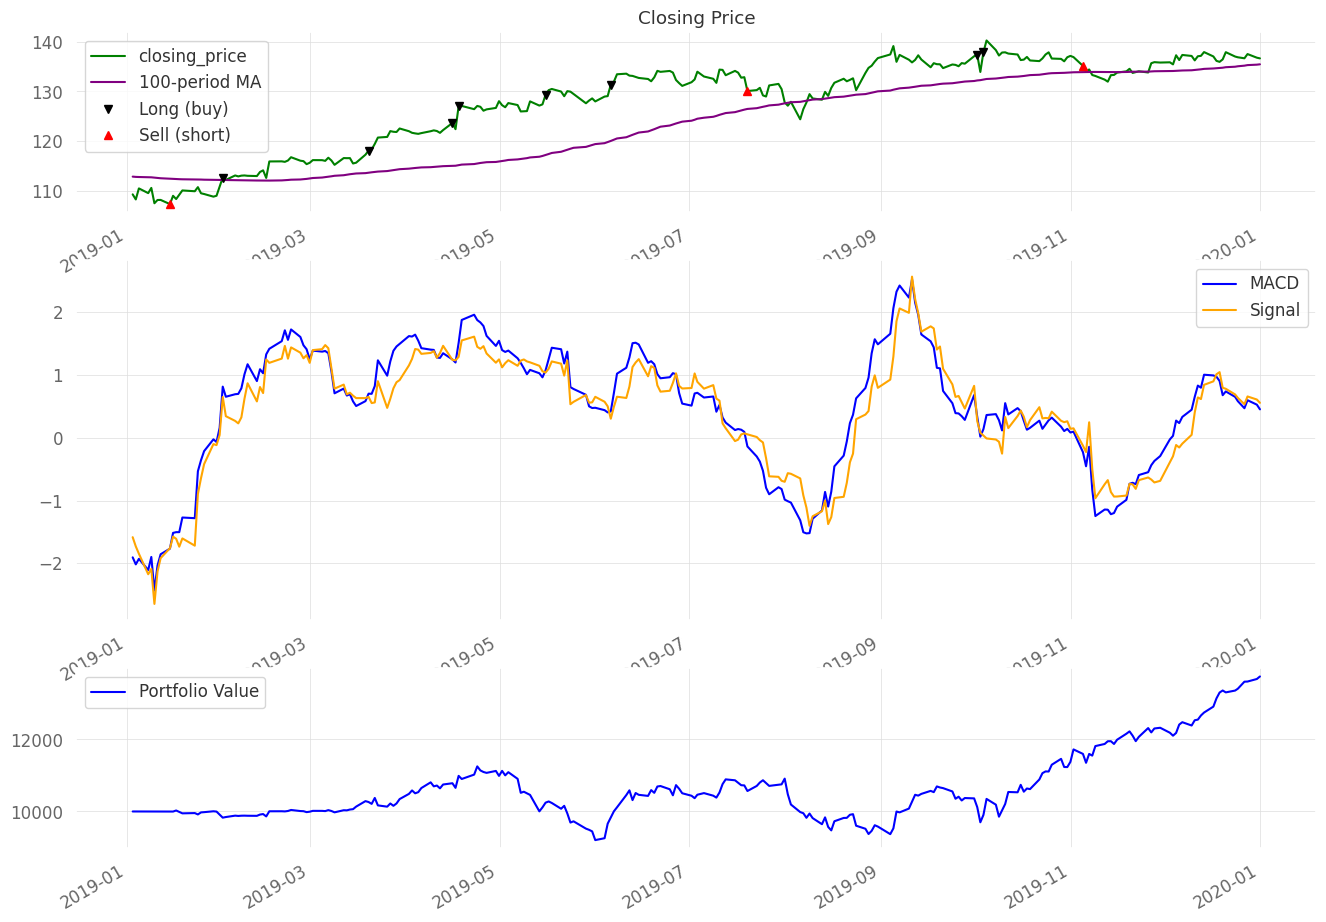

In [37]:
plot_macd(result)

## Use Benchmark 'SPY' to Compare MACD Performance

Extract a return series with time index from 'SPY' to make it compatible to use in `quantstats` library.

In [40]:
spy = pd.read_csv("custom_data/d1/spy.csv")
spy.timestamp = pd.to_datetime(spy.timestamp)
spy.set_index('timestamp',inplace=True)
spy_return_series = spy['close'].pct_change()
spy_return_series = spy_return_series['2019-01-01':'2020-01-01']

Convert the timezone to none to match it with the benchmark 'SPY'.

In [41]:
returns = result.returns
returns.index = returns.index.tz_localize(None)

### Quantstat Tearsheet for Macd 

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-15   2019-01-15
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             31.0%        100.0%

Cumulative Return          23.63%       37.52%
CAGR﹪                     16.5%        25.78%

Sharpe                     1.95         1.58
Prob. Sharpe Ratio         100.0%       93.85%
Smart Sharpe               1.83         1.48
Sortino                    7.92         2.38
Smart Sortino              7.41         2.23
Sortino/√2                 5.6          1.68
Smart Sortino/√2           5.24         1.57
Omega                      1.31         1.31

Max Drawdown               -2.13%       -18.2%
Longest DD Days            245          184
Volatility (ann.)          11.6%        22.49%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-04-24,2019-05-31,2019-10-24,184,-18.203429,-16.731510
2,2019-11-04,2019-11-05,2019-11-07,4,-3.171933,-1.472480
3,2019-03-22,2019-03-25,2019-03-29,8,-2.333339,-2.104285
4,2019-11-20,2019-11-21,2019-11-22,3,-2.217100,-1.239940
5,2019-10-29,2019-10-30,2019-10-31,3,-1.997031,-1.974898


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


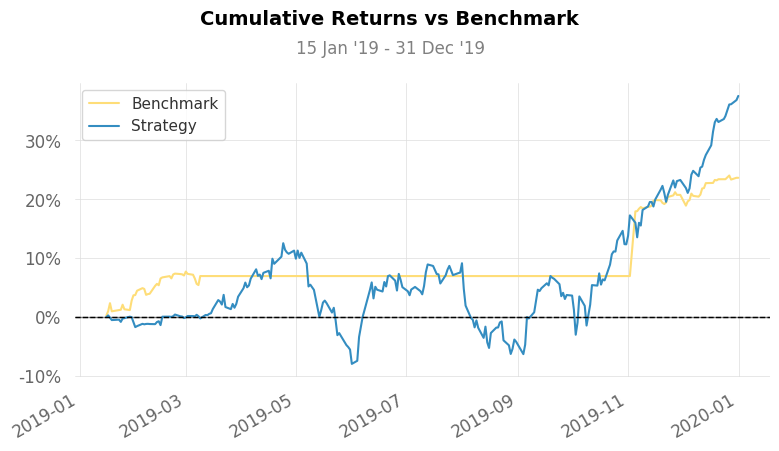

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


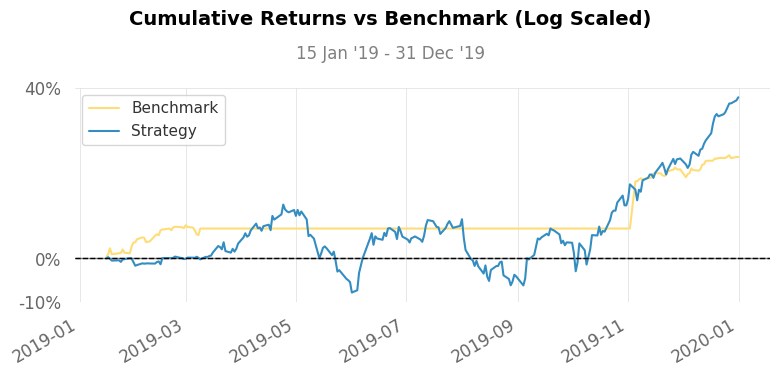

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


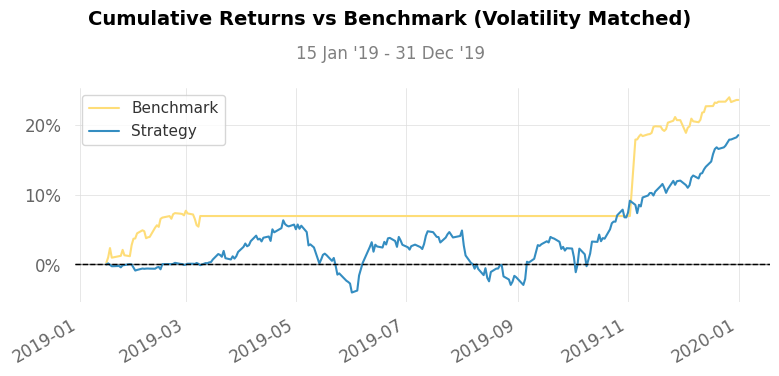

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


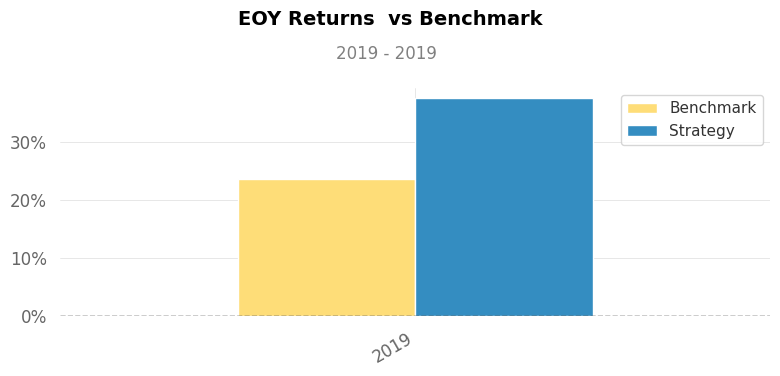

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


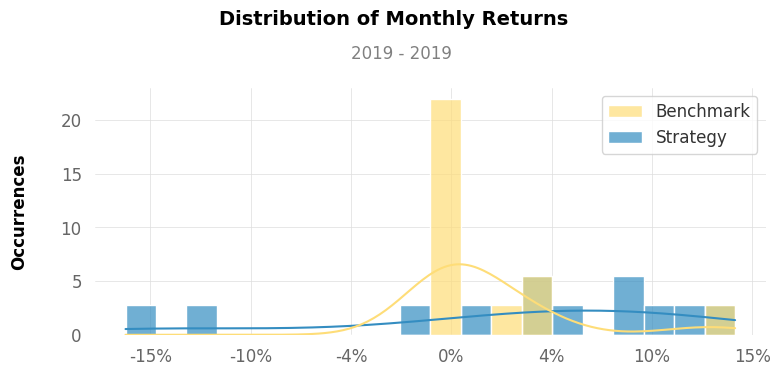

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


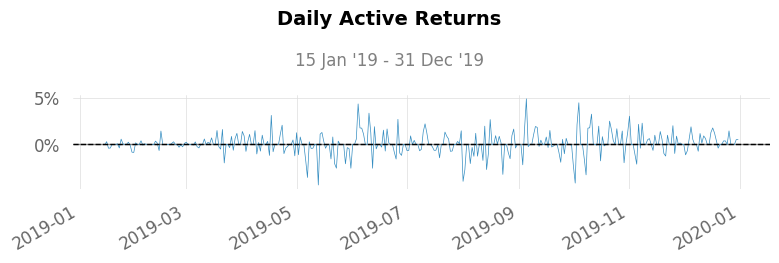

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


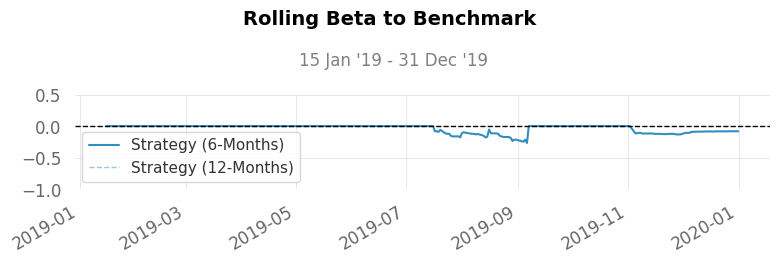

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


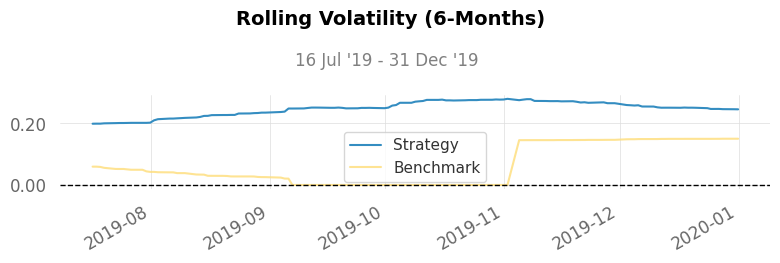

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


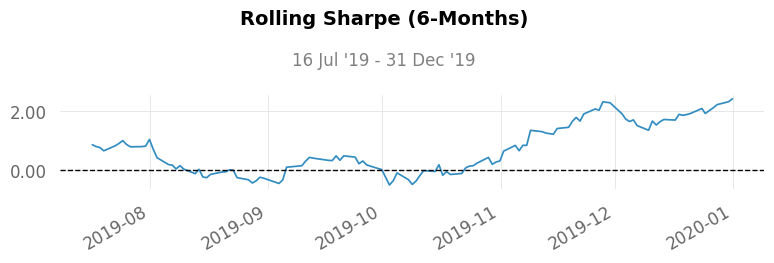

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


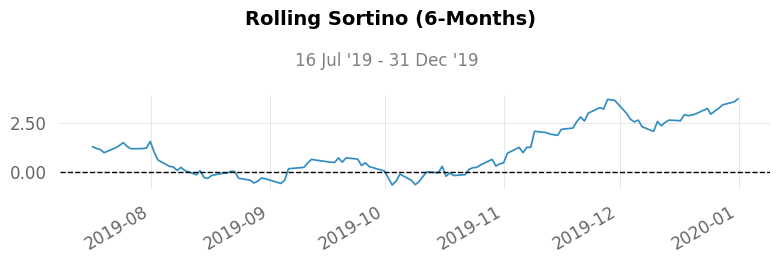

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


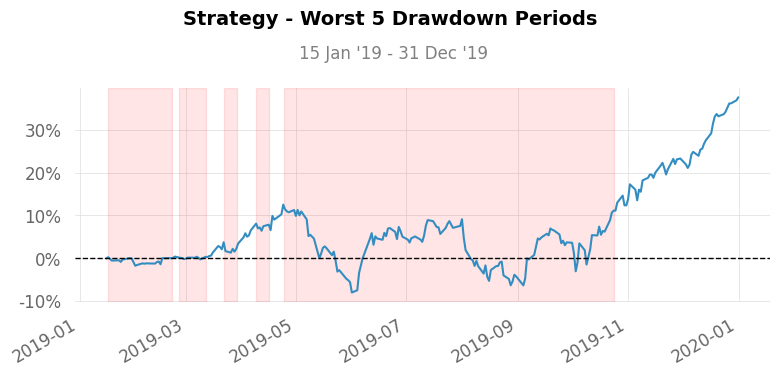

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


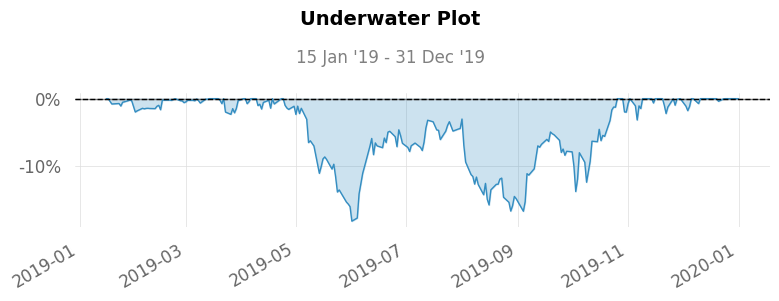

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


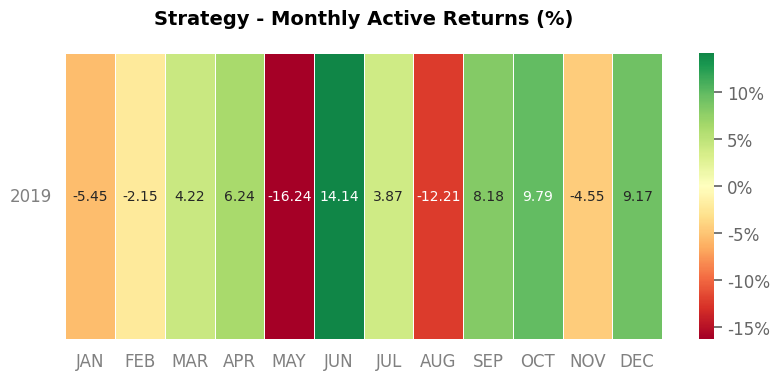

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


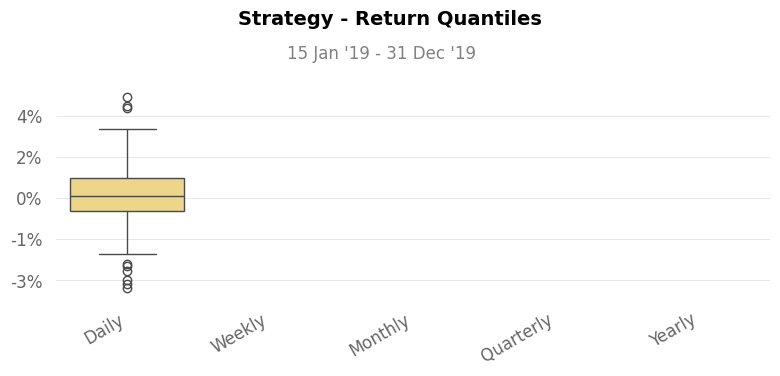

In [42]:
qs.reports.full(returns,benchmark=spy_return_series)

### **Interpretation of MACD Performance**

The strategy with MACD indicator performs comparativly better than the benchmark.<br>

**Cumulative Return**          
* Benchmark: 23.63%%        
* Strategy : 37.52%<br>

**Sharp Ratio**<br>

* Benchmark: 1.9 
* Strategy: 1.63<br>

Our strategy achieved a higher cumulative return 37.52% and its Sharpe Ratio is lower than the benchmark.<br>This suggests that the strategy generated returns at the cost of significantly higher risk or volatility, it is more risky compared to benchmark 'SPY'.<br>

**Omega**
* Benchmark: 1.31
* Strategy: 1.31<br>

Both options offer similar downside protection with Omega values around 1.31, suggesting comparable protection against major losses and has a higher probability of achieving a positive return than experiencing a loss.<br>

**Max Drawdown**
* Benchmark: -2.13%
* Strategy: -18.2%

Our strategy experienced a much deeper drawdown compared to the benchmark. This indicates our strategy exposed significantly higher potential losses. <br>

**Decission Point**
* Benchmark: Suitible for investors seeking moderate returns with lower risk tolerance.
* Strategy: Suitible for investors seeking higher returns with higher risk tolerance.<br>

# RSI as Mean Reversion Indicator

RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.<br>
The RSI is displayed as an oscillator and can have a reading from 0 to 100.<br>

**In our case we have applied the following rules:<br>**

* If the RSI is 70 or greater, then the it is assumed to be overbought (a situation in which prices have risen more than market expectations) and we generated a sell signal.<br>
* An RSI of 30 or less is taken as a signal that it may be oversold (a situation in which prices have fallen more than the market expectations) and we generated a buy signal .<br>

### RSI Function

In [10]:
def RSI(df, window, matype=1):
    rsi_period = window

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    if matype==2:
        df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
        df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()
    if matype==1:
        df['ema_gain'] = df['gain'].rolling(rsi_period).mean()
        df['ema_loss'] = df['loss'].rolling(rsi_period).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

### Bactest with Zipline (RSI)

In [11]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    context.assets = [symbol("AAPL"), symbol("XOM"), symbol("LLY"),symbol("JPM"),symbol("PEP")]

def handle_data(context, data):
    context.i += 1
    if context.i < window+1:
        return
    for asset in context.assets:
        prices = data.history(asset, ['open','close','price'], bar_count=30, frequency='1d')
        rsi_value = RSI(prices, 14,matype=2).rsi_14[-1]
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, "price")
            if rsi_value > 70:
                order_target_percent(asset, -10)
            elif rsi_value < 30:
                order_target_percent(asset, 10)
            else:
                order_target(asset, 0)

        record(closing_price=data.current(asset, 'close'),
            rsi=rsi_value)

#............................................................................................
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_rsi = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Funtions for RSI Plotting

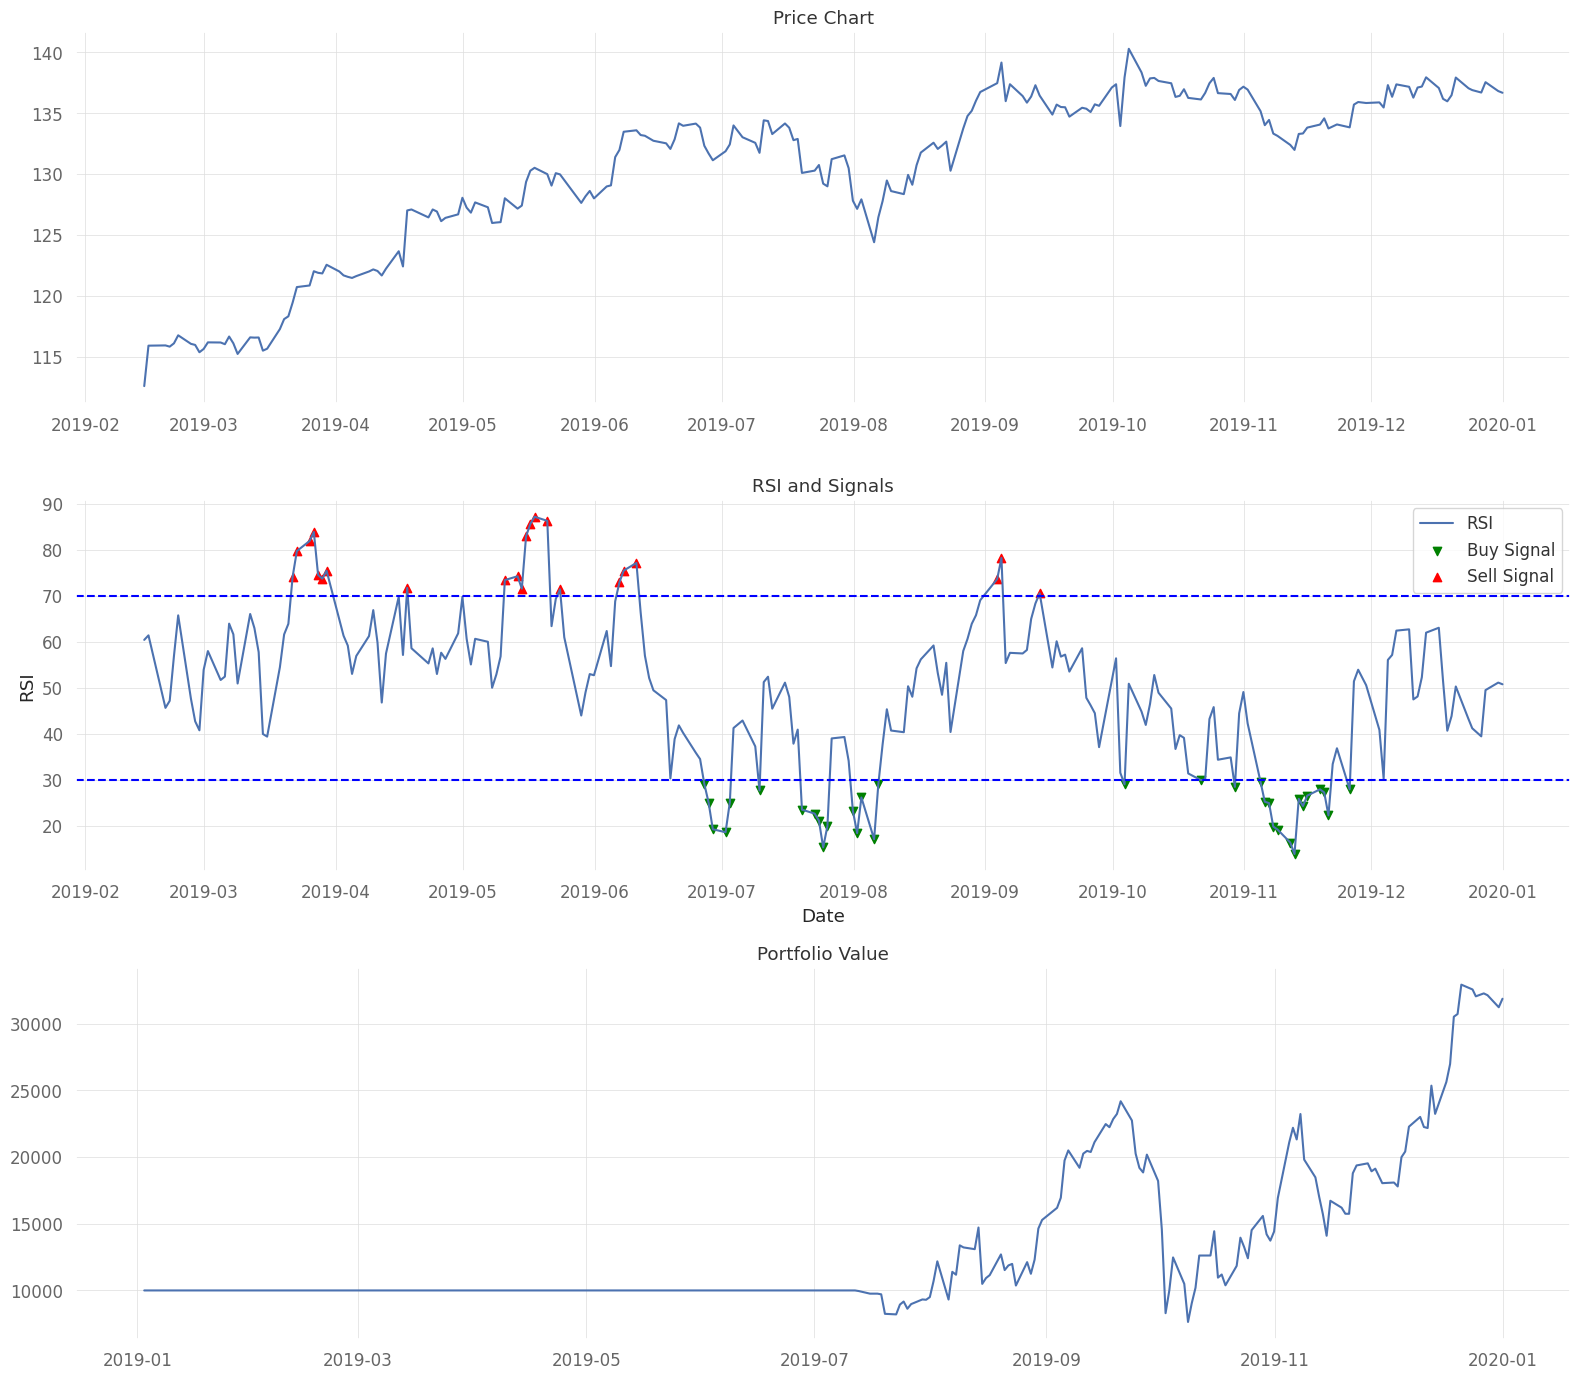

Buycount:33, Sellcount:22


In [12]:
fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price Chart')
ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

print(f'Buycount:{len(buy_signals.index)}, Sellcount:{len(sell_signals.index)}')

## Use a benchmark 'SPY' to conmpare RSI Performance

### Quantstat Tearsheet for RSI 

In [46]:
#Convert the timezone to none to avoid the warning while comparing with the benchmark
returns_rsi = result_rsi.returns
returns_rsi.index = returns_rsi.index.tz_localize(None)
qs.reports.metrics(returns_rsi,benchmark=spy_return_series)

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-02   2019-01-02
End Period          2019-12-31   2019-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      15.0%        47.0%

Cumulative Return   15.59%       218.54%
CAGR﹪              10.58%       123.52%

Sharpe              1.41         1.58
Prob. Sharpe Ratio  99.98%       93.72%
Sortino             8.6          2.37
Sortino/√2          6.08         1.68
Omega               1.5          1.5

Max Drawdown        -1.88%       -68.39%
Longest DD Days     14           80

Gain/Pain Ratio     4.1          0.5
Gain/Pain (1M)      -            64.88

Payoff Ratio        3.6          2.31
Profit Factor       5.1          1.5
Common Sense Ratio  -            2.68
CPC Index           13.39        1.93
Tail Ratio          -            1.79
Outlier Win Ratio   153.99       3.99
Outlier Loss Ratio  35.4         1.69

MTD                 2.4%         76.6%
3M            

### **Interpretation of RSI Performance**

The strategy with RSI indicator significantly outperforming the benchmark.<br>

**Cumulative Return**          
* Benchmark: 15.59%    
* Strategy : 218.54%<br>

**Sharp Ratio**<br>

* Benchmark: 1.41
* Strategy: 1.58<br>

Our strategy achieved a higher cumulative return 218.54% and its Sharpe Ratio is higher than the benchmark.<br>
It generates better returns for the same level of risk compared to the benchmark 'SPY'.<br>

**Omega**
* Benchmark: 1.5
* Strategy: 1.5<br>

Both options offer similar downside protection with Omega values around 1.5, suggesting comparable protection against major losses and has a higher probability of achieving a positive return than experiencing a loss.<br>

**Max Drawdown**
* Benchmark: -1.88%
* Strategy: -68.39%

Our strategy experienced a much deeper drawdown compared to the benchmark. This indicates our strategy exposed significantly higher potential losses. <br>

**Decission Point**
* Benchmark: Suitible for investors seeking moderate returns with lower risk tolerance.
* Strategy: Suitible for investors seeking higher returns with higher risk tolerance.<br>